Original shape: (7789, 11)
Accuracy: 1.0

Classification Report:
               precision    recall  f1-score   support

       Movie       1.00      1.00      1.00       980
     TV Show       1.00      1.00      1.00       311

    accuracy                           1.00      1291
   macro avg       1.00      1.00      1.00      1291
weighted avg       1.00      1.00      1.00      1291



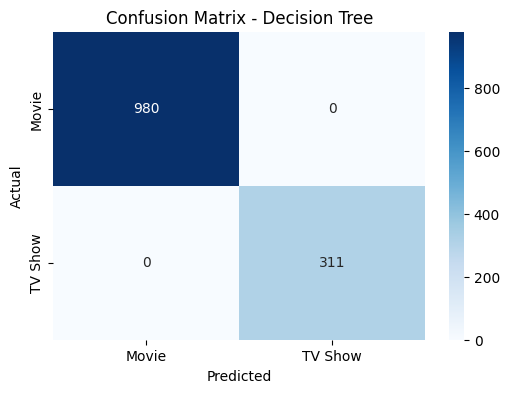

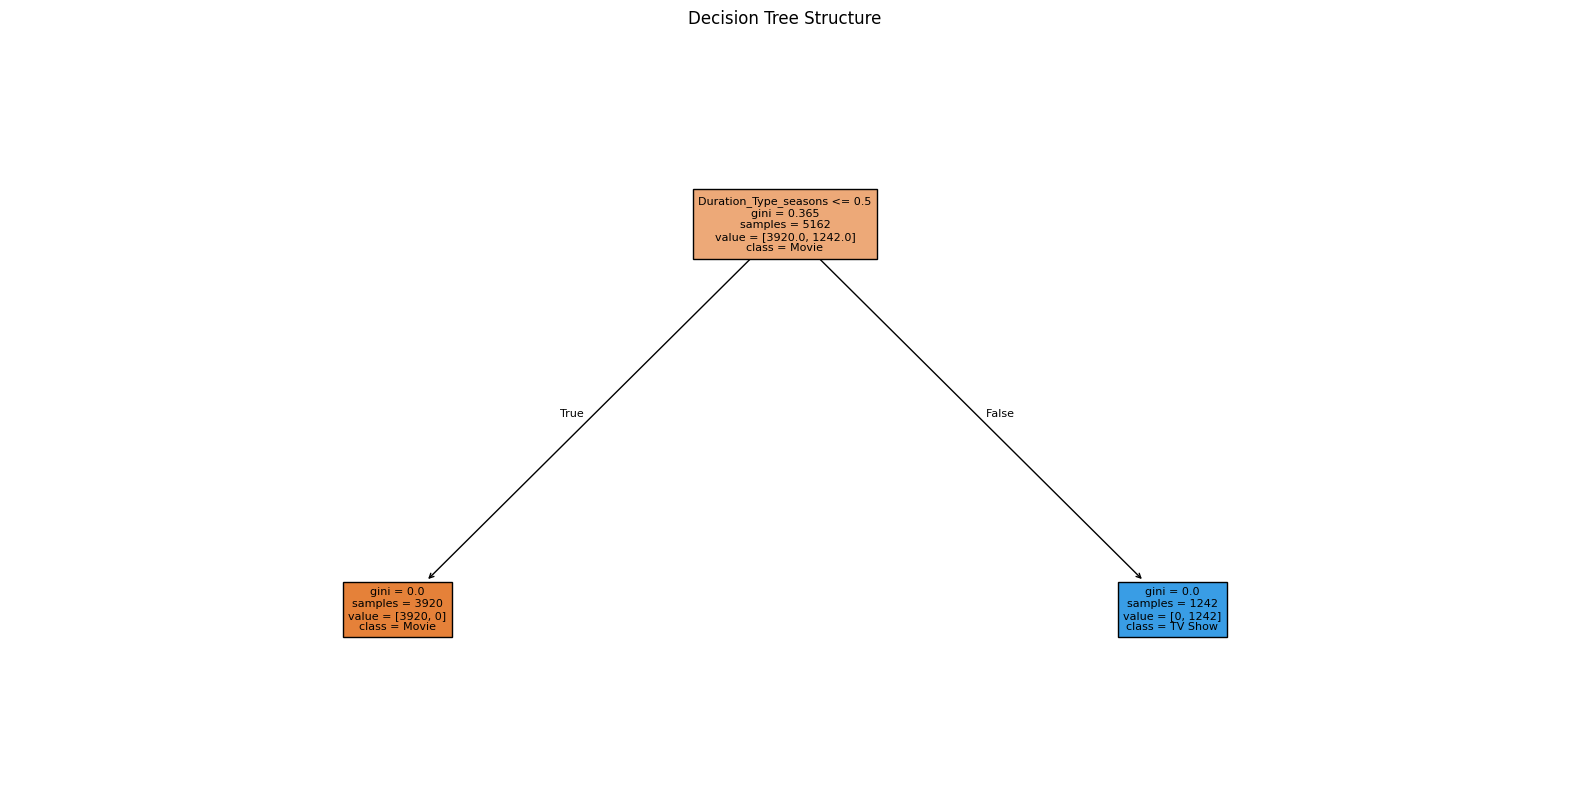

In [1]:
# Decision Tree Classification pada Dataset Netflix
# Nama: M.Rafiif Dzakwan (0102522018)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# 1. Load Data
DATA_PATH = 'Netflix Dataset.csv'  # ganti path sesuai lokasi file
df = pd.read_csv(DATA_PATH)
print("Original shape:", df.shape)

# 2. Data Cleaning
# Hapus kolom tidak relevan
drop_cols = ["Show_Id", "Title", "Director", "Cast", "Description"]
df = df.drop(columns=drop_cols, errors='ignore')

# Ubah Release_Date -> Release_Year
if "Release_Date" in df.columns:
    df["Release_Year"] = pd.to_datetime(df["Release_Date"], errors="coerce").dt.year
    df.drop(columns=["Release_Date"], inplace=True)

# Parsing Duration menjadi nilai angka dan tipe
def parse_duration(d):
    if pd.isna(d):
        return (np.nan, "unknown")
    s = str(d).strip()
    m = re.search(r'(\d+)', s)
    val = int(m.group(1)) if m else np.nan
    if "Season" in s:
        return (val, "seasons")
    elif "min" in s:
        return (val, "minutes")
    else:
        return (val, "unknown")

df[["Duration_Value", "Duration_Type"]] = df["Duration"].apply(lambda x: pd.Series(parse_duration(x)))
df.drop(columns=["Duration"], inplace=True)

# Hapus duplikat
df.drop_duplicates(inplace=True)

# Hapus missing values di kolom penting
important_cols = ["Category", "Country", "Rating", "Duration_Value", "Duration_Type", "Type", "Release_Year"]
df.dropna(subset=important_cols, inplace=True)

# 3. Outlier Removal (IQR pada Duration_Value)
Q1 = df["Duration_Value"].quantile(0.25)
Q3 = df["Duration_Value"].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
df = df[(df["Duration_Value"] >= lower_bound) & (df["Duration_Value"] <= upper_bound)]

# 4. Encoding
# Label Encoding untuk target
le = LabelEncoder()
df["Category_label"] = le.fit_transform(df["Category"])

# One Hot Encoding untuk fitur kategorikal
categorical_cols = ["Country", "Rating", "Duration_Type", "Type"]
df_encoded = pd.get_dummies(df.drop(columns=["Category", "Category_label"]), columns=categorical_cols)

# 5. Train-Test Split
X = df_encoded
y = df["Category_label"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# 6. Decision Tree Classification
dt = DecisionTreeClassifier(
    criterion='gini',
    max_depth=None,    # bisa diatur untuk menghindari overfitting
    random_state=42
)
dt.fit(X_train, y_train)

# 7. Evaluasi
y_pred = dt.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred, target_names=le.classes_))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - Decision Tree")
plt.show()

# 8. Visualisasi Pohon Keputusan
plt.figure(figsize=(20,10))
plot_tree(dt, feature_names=X.columns, class_names=le.classes_, filled=True, fontsize=8)
plt.title("Decision Tree Structure")
plt.show()
